In [9]:
import numpy as np
import os 
import tifffile as tiff
import h5py
import multiprocessing as mp
import pandas as pd
from functools import partial
import json
import matplotlib.pyplot as plt
from skimage.morphology import dilation
from PIL import Image, ImageDraw

In [2]:
# https://www.kaggle.com/paulorzp/rle-functions-run-lenght-encode-decode
def rle2mask(mask_rle, shape):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (width,height) of array to return 
    Returns numpy array, 1 - mask, 0 - background

    '''
    s = mask_rle.split()
    starts, lengths = [
        np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])
    ]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0] * shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo : hi] = 1
    return img.reshape(shape).T

In [3]:
def create_and_save_csv(pd):
    pass

def create_mask(dset_name,pathc_coords):
    pass

def pad_image(image,mask,tile_x,tile_y):
    '''
    make image padded 
    '''
    new_shape = ((image.shape[0]//tile_x+1)*tile_x,
                 (image.shape[1]//tile_y+1)*tile_y,
                 image.shape[2])
    print('old shape is {}, new one is {}'.format(image.shape,new_shape))
    new_image = np.zeros(new_shape, dtype = image.dtype)
    new_mask = np.zeros((new_shape[0],new_shape[1]), dtype = mask.dtype)
    new_image[:image.shape[0], :image.shape[1], :] = image
    new_mask[:mask.shape[0], :mask.shape[1]] = mask
    return new_image, new_mask

def get_patch_coords(shape,tile_x,tile_y):
    '''
    get starting coordinates for every patch, store in a np array
    '''
    number_x_tiles = int(np.floor(shape[0]/tile_x))
    number_y_tiles = int(np.floor(shape[1]/tile_y))
    
    left = np.array([j*tile_x for j in range(number_x_tiles)])
    top = np.array([j*tile_y for j in range(number_y_tiles)])
    
    crop_start_point = np.array(np.meshgrid(left,top))
    crop_start_point = crop_start_point.T.reshape(-1, 2)
    
    return crop_start_point

def save_tile_image(patch_coords, image,  tile_x, tile_y,filename):
    '''
    save cropped image
    '''
    new_im = image[patch_coords[0]:patch_coords[0]+tile_x,
                   patch_coords[1]:patch_coords[1]+tile_y,:]
    tiff.imwrite(filename,data = new_im, dtype = new_im.dtype)
    
def save_tile_mask(mask, patch_coords, tile_x, tile_y, file, dset):
    '''
    save cropped mask
    '''
    new_mask = mask[patch_coords[0]:patch_coords[0]+tile_x,
                   patch_coords[1]:patch_coords[1]+tile_y]
    dset_name = dset
    file.create_dataset(dset_name, data = new_mask)

def tissue_mask(json_file,shape):
    '''
    creates mask from tissue coordinates of a tissue 
    '''
    f = open(json_file)
    data = json.load(f)
    poly = []
    for structure in data:
        if structure['geometry']['type'] == 'MultiPolygon':
            for coords in structure['geometry']['coordinates']:
                poly.append(tuple(np.array(coords).flatten()))
        else:
            poly.append(tuple(np.array(structure['geometry']['coordinates']).flatten()))
    mask = Image.new('L', (shape[1],shape[0]), 0)
    for p in poly:
        ImageDraw.Draw(mask).polygon(p, outline=1, fill=1)
    mask = np.array(mask)
    return mask

def check_tissue(tissue,patch_coords,tile_x,tile_y):
    '''
    returns True if tile contains tissue
    otherwise returns False
    '''
    return np.sum(tissue[patch_coords[0]:patch_coords[0]+tile_x,
                         patch_coords[1]:patch_coords[1]+tile_y]) > 0



In [5]:
BASE_PATH = "../"
SAVE_PATH = "/run/media/alcauchy/Seagate Backup Plus Drive/kaggle/train_tissue"
TRAIN_PATH = '../train'


In [23]:
df_train = pd.read_csv(
    os.path.join(BASE_PATH, "train.csv")
)

In [24]:
df_train

,id,encoding
0,2f6ecfcdf,296084587 4 296115835 6 296115859 14 296147109...
1,aaa6a05cc,30989109 59 31007591 64 31026074 68 31044556 7...
2,cb2d976f4,78144363 5 78179297 15 78214231 25 78249165 35...
3,0486052bb,101676003 6 101701785 8 101727568 9 101753351 ...
4,e79de561c,7464094 14 7480273 41 7496453 67 7512632 82 75...
5,095bf7a1f,113430380 22 113468538 67 113506697 111 113544...
6,54f2eec69,124601765 36 124632133 109 124662536 147 12469...
7,1e2425f28,49453112 7 49479881 22 49506657 31 49533433 40...


In [25]:
h5_file.close()

In [18]:
TRAIN = 1

In [21]:
TRAIN

1

In [76]:
h5_file.close()

In [26]:
TRAIN = True
TISSUE_ONLY = True
h5_file = h5py.File(os.path.join(SAVE_PATH,'mask.h5'),'w')
df_train = pd.read_csv(
    os.path.join(BASE_PATH, "train.csv")
)
tile_name_list = []
tile_size = 256
for ind in df_train.index:
   # if ind>0:
       # break
    imagename,rle = df_train.iloc[ind]
    print(imagename)
    image = tiff.imread(os.path.join(TRAIN_PATH,imagename+'.tiff'))
    
    if image.shape[0] == 3:
        image = np.transpose(image,(1,2,0))
    if TRAIN:
        mask = rle2mask(rle,(image.shape[1],image.shape[0]))
    else:
        mask = np.zeros((image.shape[0],image.shape[1]),dtype = image.dtype)
    img_new,msk_new = pad_image(image = image,
                                mask = mask,
                                tile_x = tile_size,
                                tile_y = tile_size)
    patch_coords = get_patch_coords(img_new.shape,
                                    tile_x=tile_size,
                                    tile_y=tile_size)
    JSON_NAME = imagename+'-anatomical-structure.json'
    msk_tissue = tissue_mask(os.path.join(TRAIN_PATH,JSON_NAME),
                             img_new.shape)
    i = 0
    for patch in list(patch_coords):
        if TISSUE_ONLY:
            if check_tissue(tissue = msk_tissue, patch_coords = patch, 
                            tile_x = tile_size, tile_y = tile_size):
                tile_name = imagename+"_"+str(i)
                filename = os.path.join(SAVE_PATH,tile_name+'.tiff')

                save_tile_image(patch_coords  = patch, image = img_new,  
                                tile_x = tile_size, tile_y = tile_size,
                                filename = filename)

                save_tile_mask(msk_new, patch_coords = patch, 
                               tile_x = tile_size, tile_y = tile_size, 
                               file = h5_file, dset = tile_name)
                tile_name_list.append(tile_name)
                i+=1   
        else:
                tile_name = imagename+"_"+str(i)
                filename = os.path.join(SAVE_PATH,tile_name+'.tiff')

                save_tile_image(patch_coords  = patch, image = img_new,  
                                tile_x = tile_size, tile_y = tile_size,
                                filename = filename)

                save_tile_mask(msk_new, patch_coords = patch, 
                               tile_x = tile_size, tile_y = tile_size, 
                               file = h5_file, dset = tile_name)
                tile_name_list.append(tile_name)
                i+=1  
            
h5_file.close()
df = pd.DataFrame( data = {'name': tile_name_list})
df.to_csv(os.path.join(SAVE_PATH,'names.csv'))

2f6ecfcdf
old shape is (31278, 25794, 3), new one is (31488, 25856, 3)
aaa6a05cc
old shape is (18484, 13013, 3), new one is (18688, 13056, 3)
cb2d976f4
old shape is (34940, 49548, 3), new one is (35072, 49664, 3)
0486052bb
old shape is (25784, 34937, 3), new one is (25856, 35072, 3)
e79de561c
old shape is (16180, 27020, 3), new one is (16384, 27136, 3)
095bf7a1f
old shape is (38160, 39000, 3), new one is (38400, 39168, 3)
54f2eec69
old shape is (30440, 22240, 3), new one is (30464, 22272, 3)
1e2425f28
old shape is (26780, 32220, 3), new one is (26880, 32256, 3)


# Create dilation mask to detect borders

In [27]:
filename = os.path.join(SAVE_PATH,'borders.h5')
filename
file = h5py.File(filename,'w')


In [28]:
mask_file = h5py.File(os.path.join(SAVE_PATH,
                                  'mask.h5'),'r')

for key in mask_file.keys():
    dset_mask = mask_file[key][()]
    dilate = dilation(dset_mask)
    border = dilate - dset_mask
    file.create_dataset(key,data = border)
    print(key)
file.close()
mask_file.close()


0486052bb_0
0486052bb_1
0486052bb_10
0486052bb_100
0486052bb_101
0486052bb_102
0486052bb_103
0486052bb_104
0486052bb_105
0486052bb_106
0486052bb_107
0486052bb_108
0486052bb_109
0486052bb_11
0486052bb_110
0486052bb_111
0486052bb_112
0486052bb_113
0486052bb_114
0486052bb_115
0486052bb_116
0486052bb_117
0486052bb_118
0486052bb_119
0486052bb_12
0486052bb_120
0486052bb_121
0486052bb_122
0486052bb_123
0486052bb_124
0486052bb_125
0486052bb_126
0486052bb_127
0486052bb_128
0486052bb_129
0486052bb_13
0486052bb_130
0486052bb_131
0486052bb_132
0486052bb_133
0486052bb_134
0486052bb_135
0486052bb_136
0486052bb_137
0486052bb_138
0486052bb_139
0486052bb_14
0486052bb_140
0486052bb_141
0486052bb_142
0486052bb_143
0486052bb_144
0486052bb_145
0486052bb_146
0486052bb_147
0486052bb_148
0486052bb_149
0486052bb_15
0486052bb_150
0486052bb_151
0486052bb_152
0486052bb_153
0486052bb_154
0486052bb_155
0486052bb_156
0486052bb_157
0486052bb_158
0486052bb_159
0486052bb_16
0486052bb_160
0486052bb_161
0486052bb_162
048

095bf7a1f_28
095bf7a1f_280
095bf7a1f_281
095bf7a1f_282
095bf7a1f_283
095bf7a1f_284
095bf7a1f_285
095bf7a1f_286
095bf7a1f_287
095bf7a1f_288
095bf7a1f_289
095bf7a1f_29
095bf7a1f_290
095bf7a1f_291
095bf7a1f_292
095bf7a1f_293
095bf7a1f_294
095bf7a1f_295
095bf7a1f_296
095bf7a1f_297
095bf7a1f_298
095bf7a1f_299
095bf7a1f_3
095bf7a1f_30
095bf7a1f_300
095bf7a1f_301
095bf7a1f_302
095bf7a1f_303
095bf7a1f_304
095bf7a1f_305
095bf7a1f_306
095bf7a1f_307
095bf7a1f_308
095bf7a1f_309
095bf7a1f_31
095bf7a1f_310
095bf7a1f_311
095bf7a1f_312
095bf7a1f_313
095bf7a1f_314
095bf7a1f_315
095bf7a1f_316
095bf7a1f_317
095bf7a1f_318
095bf7a1f_319
095bf7a1f_32
095bf7a1f_320
095bf7a1f_321
095bf7a1f_322
095bf7a1f_323
095bf7a1f_324
095bf7a1f_325
095bf7a1f_326
095bf7a1f_327
095bf7a1f_328
095bf7a1f_329
095bf7a1f_33
095bf7a1f_330
095bf7a1f_331
095bf7a1f_332
095bf7a1f_333
095bf7a1f_334
095bf7a1f_335
095bf7a1f_336
095bf7a1f_337
095bf7a1f_338
095bf7a1f_339
095bf7a1f_34
095bf7a1f_340
095bf7a1f_341
095bf7a1f_342
095bf7a1f_343
0

1e2425f28_258
1e2425f28_259
1e2425f28_26
1e2425f28_260
1e2425f28_261
1e2425f28_262
1e2425f28_263
1e2425f28_264
1e2425f28_265
1e2425f28_266
1e2425f28_267
1e2425f28_268
1e2425f28_269
1e2425f28_27
1e2425f28_270
1e2425f28_271
1e2425f28_272
1e2425f28_273
1e2425f28_274
1e2425f28_275
1e2425f28_276
1e2425f28_277
1e2425f28_278
1e2425f28_279
1e2425f28_28
1e2425f28_280
1e2425f28_281
1e2425f28_282
1e2425f28_283
1e2425f28_284
1e2425f28_285
1e2425f28_286
1e2425f28_287
1e2425f28_288
1e2425f28_289
1e2425f28_29
1e2425f28_290
1e2425f28_291
1e2425f28_292
1e2425f28_293
1e2425f28_294
1e2425f28_295
1e2425f28_296
1e2425f28_297
1e2425f28_298
1e2425f28_299
1e2425f28_3
1e2425f28_30
1e2425f28_300
1e2425f28_301
1e2425f28_302
1e2425f28_303
1e2425f28_304
1e2425f28_305
1e2425f28_306
1e2425f28_307
1e2425f28_308
1e2425f28_309
1e2425f28_31
1e2425f28_310
1e2425f28_311
1e2425f28_312
1e2425f28_313
1e2425f28_314
1e2425f28_315
1e2425f28_316
1e2425f28_317
1e2425f28_318
1e2425f28_319
1e2425f28_32
1e2425f28_320
1e2425f28_321
1

2f6ecfcdf_276
2f6ecfcdf_277
2f6ecfcdf_278
2f6ecfcdf_279
2f6ecfcdf_28
2f6ecfcdf_280
2f6ecfcdf_281
2f6ecfcdf_282
2f6ecfcdf_283
2f6ecfcdf_284
2f6ecfcdf_285
2f6ecfcdf_286
2f6ecfcdf_287
2f6ecfcdf_288
2f6ecfcdf_289
2f6ecfcdf_29
2f6ecfcdf_290
2f6ecfcdf_291
2f6ecfcdf_292
2f6ecfcdf_293
2f6ecfcdf_294
2f6ecfcdf_295
2f6ecfcdf_296
2f6ecfcdf_297
2f6ecfcdf_298
2f6ecfcdf_299
2f6ecfcdf_3
2f6ecfcdf_30
2f6ecfcdf_300
2f6ecfcdf_301
2f6ecfcdf_302
2f6ecfcdf_303
2f6ecfcdf_304
2f6ecfcdf_305
2f6ecfcdf_306
2f6ecfcdf_307
2f6ecfcdf_308
2f6ecfcdf_309
2f6ecfcdf_31
2f6ecfcdf_310
2f6ecfcdf_311
2f6ecfcdf_312
2f6ecfcdf_313
2f6ecfcdf_314
2f6ecfcdf_315
2f6ecfcdf_316
2f6ecfcdf_317
2f6ecfcdf_318
2f6ecfcdf_319
2f6ecfcdf_32
2f6ecfcdf_320
2f6ecfcdf_321
2f6ecfcdf_322
2f6ecfcdf_323
2f6ecfcdf_324
2f6ecfcdf_325
2f6ecfcdf_326
2f6ecfcdf_327
2f6ecfcdf_328
2f6ecfcdf_329
2f6ecfcdf_33
2f6ecfcdf_330
2f6ecfcdf_331
2f6ecfcdf_332
2f6ecfcdf_333
2f6ecfcdf_334
2f6ecfcdf_335
2f6ecfcdf_336
2f6ecfcdf_337
2f6ecfcdf_338
2f6ecfcdf_339
2f6ecfcdf_34
2

cb2d976f4_11
cb2d976f4_110
cb2d976f4_111
cb2d976f4_112
cb2d976f4_113
cb2d976f4_114
cb2d976f4_115
cb2d976f4_116
cb2d976f4_117
cb2d976f4_118
cb2d976f4_119
cb2d976f4_12
cb2d976f4_120
cb2d976f4_121
cb2d976f4_122
cb2d976f4_123
cb2d976f4_124
cb2d976f4_125
cb2d976f4_126
cb2d976f4_127
cb2d976f4_128
cb2d976f4_129
cb2d976f4_13
cb2d976f4_130
cb2d976f4_131
cb2d976f4_132
cb2d976f4_133
cb2d976f4_134
cb2d976f4_135
cb2d976f4_136
cb2d976f4_137
cb2d976f4_138
cb2d976f4_139
cb2d976f4_14
cb2d976f4_140
cb2d976f4_141
cb2d976f4_142
cb2d976f4_143
cb2d976f4_144
cb2d976f4_145
cb2d976f4_146
cb2d976f4_147
cb2d976f4_148
cb2d976f4_149
cb2d976f4_15
cb2d976f4_150
cb2d976f4_151
cb2d976f4_152
cb2d976f4_153
cb2d976f4_154
cb2d976f4_155
cb2d976f4_156
cb2d976f4_157
cb2d976f4_158
cb2d976f4_159
cb2d976f4_16
cb2d976f4_160
cb2d976f4_161
cb2d976f4_162
cb2d976f4_163
cb2d976f4_164
cb2d976f4_165
cb2d976f4_166
cb2d976f4_167
cb2d976f4_168
cb2d976f4_169
cb2d976f4_17
cb2d976f4_170
cb2d976f4_171
cb2d976f4_172
cb2d976f4_173
cb2d976f4_174

cb2d976f4_642
cb2d976f4_643
cb2d976f4_644
cb2d976f4_645
cb2d976f4_646
cb2d976f4_647
cb2d976f4_648
cb2d976f4_649
cb2d976f4_65
cb2d976f4_650
cb2d976f4_651
cb2d976f4_652
cb2d976f4_653
cb2d976f4_654
cb2d976f4_655
cb2d976f4_656
cb2d976f4_657
cb2d976f4_658
cb2d976f4_659
cb2d976f4_66
cb2d976f4_660
cb2d976f4_661
cb2d976f4_662
cb2d976f4_663
cb2d976f4_664
cb2d976f4_665
cb2d976f4_666
cb2d976f4_667
cb2d976f4_668
cb2d976f4_669
cb2d976f4_67
cb2d976f4_670
cb2d976f4_671
cb2d976f4_672
cb2d976f4_673
cb2d976f4_674
cb2d976f4_675
cb2d976f4_676
cb2d976f4_677
cb2d976f4_678
cb2d976f4_679
cb2d976f4_68
cb2d976f4_680
cb2d976f4_681
cb2d976f4_682
cb2d976f4_683
cb2d976f4_684
cb2d976f4_685
cb2d976f4_686
cb2d976f4_687
cb2d976f4_688
cb2d976f4_689
cb2d976f4_69
cb2d976f4_690
cb2d976f4_691
cb2d976f4_7
cb2d976f4_70
cb2d976f4_71
cb2d976f4_72
cb2d976f4_73
cb2d976f4_74
cb2d976f4_75
cb2d976f4_76
cb2d976f4_77
cb2d976f4_78
cb2d976f4_79
cb2d976f4_8
cb2d976f4_80
cb2d976f4_81
cb2d976f4_82
cb2d976f4_83
cb2d976f4_84
cb2d976f4_85
cb2

In [22]:
firstKey = '0486052bb_164'
dset_mask = mask_file[firstKey][()]
dilate = dilation(dset_mask)

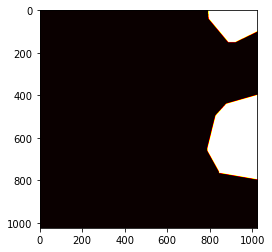

In [21]:
plt.imshow(dset_mask,cmap = 'hot')


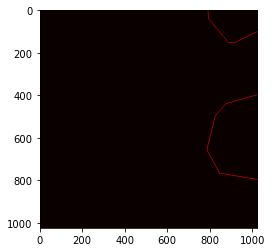

In [25]:
plt.imshow(dilate-dset_mask,cmap = 'hot')

In [37]:
filename = os.path.join(SAVE_PATH,'borders.h5')
file = h5py.File(filename,'r')
firstKey = '0486052bb_164'
dilated = file[firstKey][()]

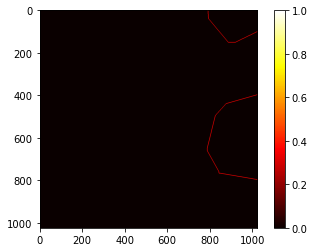

In [38]:
plt.imshow(dilated,cmap = 'hot')
plt.colorbar()

In [40]:
dilated[np.nonzero(dilated)]
file.close()

In [ ]:
dilated